<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/CIFAR100_Compare_UNET_architectures_and_objective_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/colorization'

Mounted at /content/drive
/content/drive/MyDrive/colorization


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [53]:

def stack_lab(l, ab):
  return torch.cat((l, ab), dim=-3)

def lab2rgb(lab, to_numpy):
  dims = len(lab.shape)
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0)) if dims==3 else lab.permute((0,2,3,1))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy(rgb).permute(2,0,1) if dims==3 else torch.from_numpy(rgb).permute((0,3,1,2))

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. using CIFAR100

In [4]:
class labColorizationDataset(Dataset):
    def __init__(self,root='./data', train=True, transform=None):
        self.cifar100 = datasets.CIFAR100(root=root, train=train, download=True, transform=transform)

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, index):
        image, label = self.cifar100[index]

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))

        return L, ab

In [5]:
train_data = labColorizationDataset(
    root='./data',
    train=True,
    transform = None
)

test_data = labColorizationDataset(
    root='./data',
    train=False,
    transform = None
)
len(train_data), len(test_data)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [6]:
gray, chrome = train_data[69]
gray.shape, chrome.shape

(torch.Size([1, 32, 32]), torch.Size([2, 32, 32]))

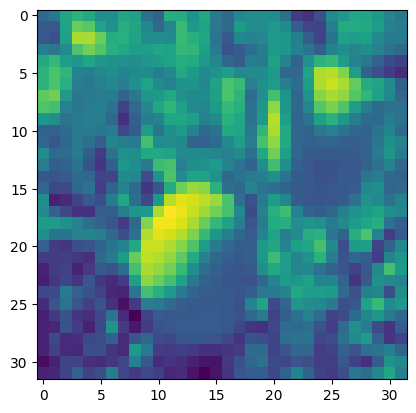

In [7]:
plt.imshow(gray[0])

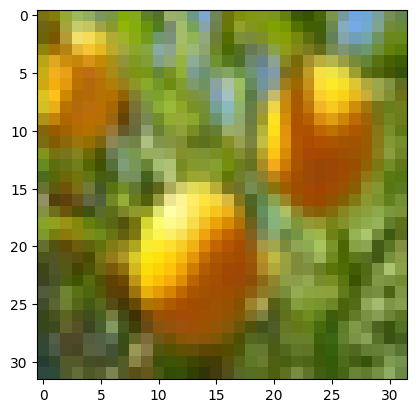

In [8]:
rgb = to_rgb(gray, chrome)
plt.imshow(rgb)

# II. Preparing the Model

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if self.batch_norm:
          self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        if self.batch_norm:
          x = self.bn(x)
        return x


In [10]:
class SkipDecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        # output_size = (input_size - 1) * stride + kernel_size - 2 * padding
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + out_channels, out_channels, batch_norm)

    def forward(self, x, x1):
        y1 = self.up_conv(x)
        y2 = torch.cat((y1, x1), dim=-3)
        y = self.conv(y2)
        return y

class NoSkipDecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        # output_size = (input_size - 1) * stride + kernel_size - 2 * padding
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels, out_channels, batch_norm)

    def forward(self, x):
        y1 = self.up_conv(x)
        y = self.conv(y1)
        return y

In [11]:
class UNet(nn.Module):
    def __init__(self, size, skip, batch_norm=False):
        super().__init__()
        self.skip = skip

        # non trainable layers
        self.pool = nn.MaxPool2d(kernel_size=2)

        # trainable layers
        ## encoder
        self.en_conv1 = DoubleConv(1,size, batch_norm)
        self.en_conv2 = DoubleConv(size,size*2, batch_norm)
        self.en_conv3 = DoubleConv(size*2,size*4, batch_norm)
        self.en_conv4 = DoubleConv(size*4,size*8, batch_norm)

        ## bottleneck
        self.conv = DoubleConv(size*8,size*16, batch_norm)

        ## decoder
        self.de_conv4 = SkipDecoderConv(size*16,size*8, batch_norm) if self.skip else NoSkipDecoderConv(size*16,size*8, batch_norm)
        self.de_conv3 = SkipDecoderConv(size*8,size*4, batch_norm) if self.skip else NoSkipDecoderConv(size*8,size*4, batch_norm)
        self.de_conv2 = SkipDecoderConv(size*4,size*2, batch_norm) if self.skip else NoSkipDecoderConv(size*4,size*2, batch_norm)
        self.de_conv1 = SkipDecoderConv(size*2,size, batch_norm) if self.skip else NoSkipDecoderConv(size*2,size, batch_norm)

        ## reconstruct layer
        self.reconstruct = nn.Conv2d(size, 2, kernel_size=3, padding=1)

    def forward(self, x):
      # encoder inference
        e1 = self.en_conv1(x)
        p1 = self.pool(e1)
        e2 = self.en_conv2(p1)
        p2 = self.pool(e2)
        e3 = self.en_conv3(p2)
        p3 = self.pool(e3)
        e4 = self.en_conv4(p3)
        p4 = self.pool(e4)
      # bottleneck inference
        b = self.conv(p4)
      # decoder inference
        d4 = self.de_conv4(b,e4) if self.skip else self.de_conv4(b)
        d3 = self.de_conv3(d4,e3) if self.skip else self.de_conv3(d4)
        d2 = self.de_conv2(d3,e2) if self.skip else self.de_conv2(d3)
        d1 = self.de_conv1(d2,e1) if self.skip else self.de_conv1(d2)

      # reconstruct image
        colors = self.reconstruct(d1)
        # print(colored_image.shape)

        return colors

# III. Training Experimentation

## 0. utils

In [12]:
from tqdm import tqdm

def train_loop(model, loader, optimizer, backprop_loss=1):
    model.train()
    running_loss1 = 0.0
    running_loss2 = 0.0

    for grayscale_images, colored_images in tqdm(loader, leave=False):
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)
        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss1 = nn.L1Loss()(predicted_images, colored_images)
        loss2 = nn.MSELoss()(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss = loss1 + loss2 if backprop_loss==0 else loss1 if backprop_loss==1 else loss2
        loss.backward()
        optimizer.step()

        running_loss1 += loss1.item()
        running_loss2 += loss2.item()

    # Calculate average loss
    average_loss1 = running_loss1 / len(loader)
    average_loss2 = running_loss2 / len(loader)

    return average_loss1, average_loss2

def plot_loss(loss, title, save_path):
    epochs = range(len(loss))

    # Plotting the losses
    plt.plot(epochs, loss)
    # Customize the plot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)

    # Save the plot
    plt.savefig(save_path)
    plt.show()

    # Close the plot to free up resources
    plt.close()

def compare_plot(data, name):
    fig, axes = plt.subplots(2, 1)

    for model, losses in data.items():
        epochs = range(len(losses[0]))
        axes[0].plot(epochs, losses[0], label=model)
        axes[1].plot(epochs, losses[1], label=model)

    axes[0].set_title('MAE')
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('loss')
    axes[0].legend()

    axes[1].set_title('MSE')
    axes[1].set_xlabel('epochs')
    axes[1].set_ylabel('loss')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f'plots/{name}.png')
    plt.show()

    # Close the plot to free up resources
    plt.close()

def train(model_name, model_size, skip_connections, batch_norm, backprop_loss, data, batch_size=256, epochs=20 ):
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    # Initialize U-Net model
    model = UNet(model_size, skip_connections, batch_norm)
    model.to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters())

    l1_hist = []
    l2_hist = []
    for epoch in range(epochs):
        l1, l2 = train_loop(model, loader, optimizer, backprop_loss)
        print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
        l1_hist.append(l1)
        l2_hist.append(l2)
    torch.save(model.state_dict(), f'models/{model_name}.pth')
    plot_loss(l1_hist, 'mean absolute error', f'plots/L1-{model_name}.png')
    plot_loss(l2_hist, 'mean squared error', f'plots/L2-{model_name}.png')

    return l1_hist, l2_hist


## Compare Importance of skip connections
 In this section we will train two models. One with skip connections and the other without it.
 We will compare the results to see if skip connections are good for colorization tasks

Epoch 1/15:  MAE Loss: 10.610497820134066, MSE Loss: 262.9727642292879


Epoch 2/15:  MAE Loss: 10.388622716981537, MSE Loss: 254.10134155896245


Epoch 3/15:  MAE Loss: 10.290035904670248, MSE Loss: 250.83538359038684


Epoch 4/15:  MAE Loss: 10.22129225730896, MSE Loss: 248.09979598376216


Epoch 5/15:  MAE Loss: 10.196489786615176, MSE Loss: 246.33075729681522


Epoch 6/15:  MAE Loss: 10.169748457110657, MSE Loss: 244.85521768063916


Epoch 7/15:  MAE Loss: 10.130882088018923, MSE Loss: 242.72630792734574


Epoch 8/15:  MAE Loss: 10.110350277959084, MSE Loss: 241.70400004484216


Epoch 9/15:  MAE Loss: 10.093517809498067, MSE Loss: 240.75750561149752


Epoch 10/15:  MAE Loss: 10.069190507032433, MSE Loss: 239.4325047707071


Epoch 11/15:  MAE Loss: 10.057221831107626, MSE Loss: 238.60260406805546


Epoch 12/15:  MAE Loss: 10.032084445564115, MSE Loss: 237.5079790232133


Epoch 13/15:  MAE Loss: 10.026859779747165, MSE Loss: 237.00676345825195


Epoch 14/15:  MAE Loss: 10.006475088547687, MSE Loss: 235.88874497705575


Epoch 15/15:  MAE Loss: 9.985396351133074, MSE Loss: 234.99810876651685


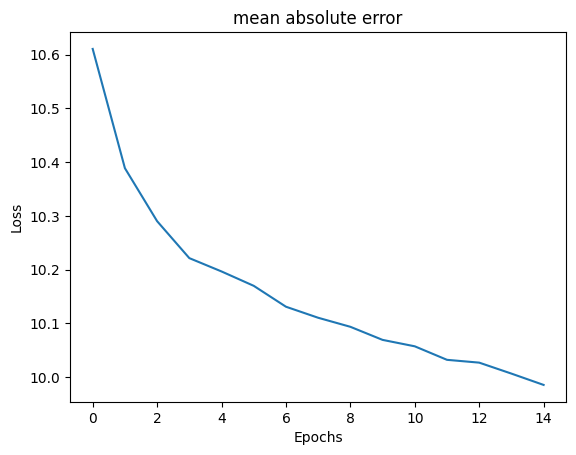

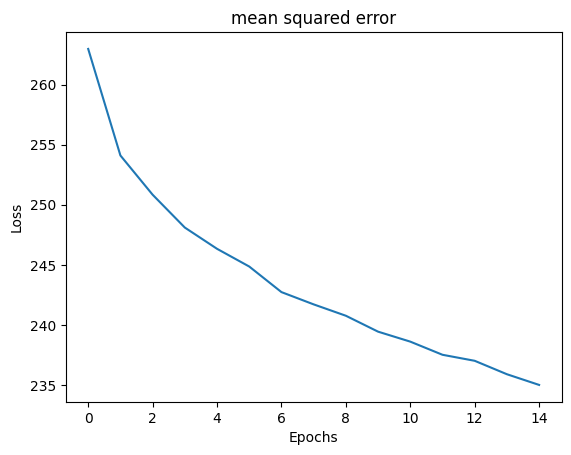

In [13]:
# unet with skip connections trained on L1 loss
skip_dict = {}

l1_skip = train(
    model_name = 'CIFAR-L1-skip',
    model_size = 4,
    skip_connections = True,
    batch_norm = False,
    backprop_loss = 1,
    data = train_data,
    epochs = 15
)

skip_dict['l1_skip'] = l1_skip


Epoch 1/15:  MAE Loss: 10.68478223742271, MSE Loss: 266.90111479467276


Epoch 2/15:  MAE Loss: 10.517782683275184, MSE Loss: 258.6364552244848


Epoch 3/15:  MAE Loss: 10.41897639449762, MSE Loss: 255.24934869883012


Epoch 4/15:  MAE Loss: 10.35048128634083, MSE Loss: 252.149165562221


Epoch 5/15:  MAE Loss: 10.309497551042206, MSE Loss: 250.39909806543466


Epoch 6/15:  MAE Loss: 10.279695272445679, MSE Loss: 248.8630652914242


Epoch 7/15:  MAE Loss: 10.251657018856127, MSE Loss: 247.45561529665576


Epoch 8/15:  MAE Loss: 10.217915359808474, MSE Loss: 245.66201914573202


Epoch 9/15:  MAE Loss: 10.208705809651589, MSE Loss: 245.3640694910166


Epoch 10/15:  MAE Loss: 10.192378905354714, MSE Loss: 244.38708768572127


Epoch 11/15:  MAE Loss: 10.164724607856906, MSE Loss: 243.26806718475964


Epoch 12/15:  MAE Loss: 10.145963445001719, MSE Loss: 242.2614565479512


Epoch 13/15:  MAE Loss: 10.1299295766013, MSE Loss: 241.4484185977858


Epoch 14/15:  MAE Loss: 10.120174811810863, MSE Loss: 240.98247823909838


Epoch 15/15:  MAE Loss: 10.093836297794264, MSE Loss: 239.55886988737146


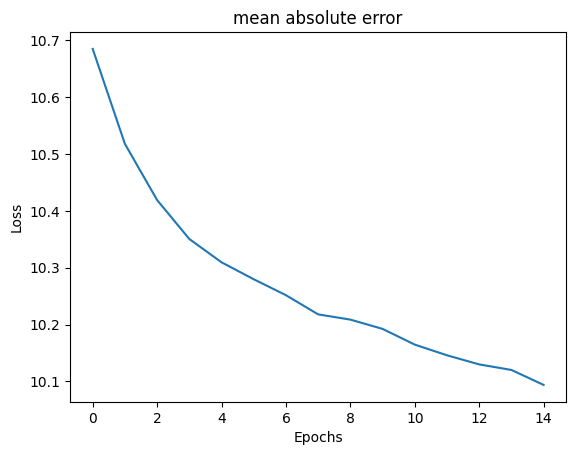

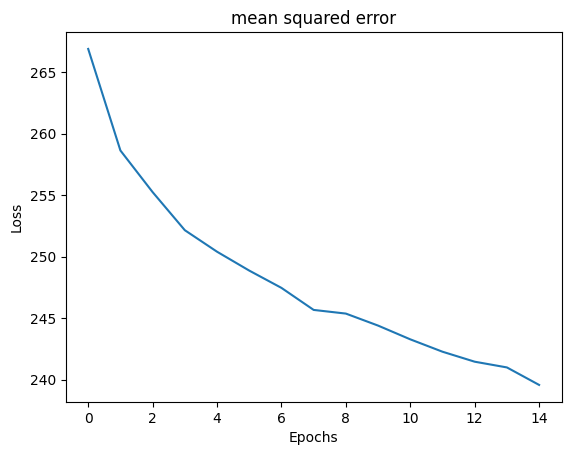

In [15]:
# unet without skip connections trained on L1 loss
l1_noskip = train(
    model_name = 'CIFAR-L1-noskip',
    model_size = 4,
    skip_connections = False,
    batch_norm = False,
    backprop_loss = 1,
    data = train_data,
    epochs=15
)

skip_dict['l1_noskip'] = l1_noskip

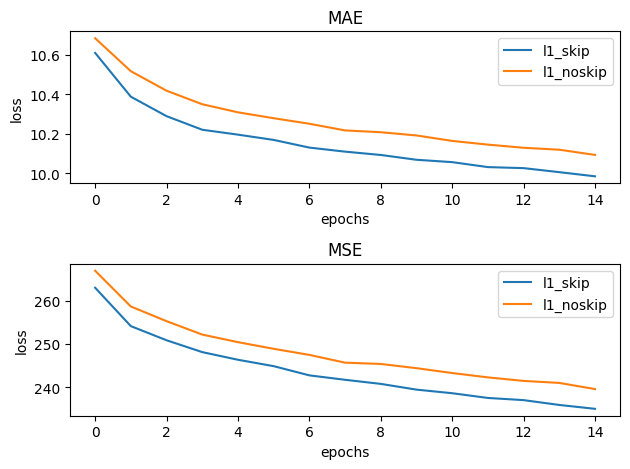

In [16]:
# compare skip to noskip
compare_plot(skip_dict, 'skip_connections')

In the plot above we compared the convergence of a two Unet models:

*   l1_skip: is a unet with skip connections trained with a L1/MAE loss function
*   l1_skip: is the same but without skip connections

We can see that skip connections have a good effect on the convergence of both metrics MAE and MSE during training.

We will keep skip connections in future implementation.

## Compare batch normalisation effect

For this section we will try batch normalisation and compare results to see if it benefits the convergence of the model

Epoch 1/15:  MAE Loss: 10.778999766524958, MSE Loss: 276.31829639356965


Epoch 2/15:  MAE Loss: 10.216068121851707, MSE Loss: 247.5258914402553


Epoch 3/15:  MAE Loss: 10.064652438066444, MSE Loss: 238.29753097222775


Epoch 4/15:  MAE Loss: 10.000903621011851, MSE Loss: 234.8083830852898


Epoch 5/15:  MAE Loss: 9.940819000711246, MSE Loss: 231.74178329779178


Epoch 6/15:  MAE Loss: 9.902057633108022, MSE Loss: 229.49081888004224


Epoch 7/15:  MAE Loss: 9.857777045697581, MSE Loss: 227.2766339827557


Epoch 8/15:  MAE Loss: 9.816326613328895, MSE Loss: 225.80881819433097


Epoch 9/15:  MAE Loss: 9.7843905906288, MSE Loss: 223.9479206630162


Epoch 10/15:  MAE Loss: 9.731298548834664, MSE Loss: 221.34971688718213


Epoch 11/15:  MAE Loss: 9.691630095851664, MSE Loss: 219.71495095077827


Epoch 12/15:  MAE Loss: 9.656203848975045, MSE Loss: 218.26799945442045


Epoch 13/15:  MAE Loss: 9.607906657822278, MSE Loss: 216.22621092504386


Epoch 14/15:  MAE Loss: 9.564382066532056, MSE Loss: 214.04110803409498


Epoch 15/15:  MAE Loss: 9.521433071214325, MSE Loss: 212.27928745503328


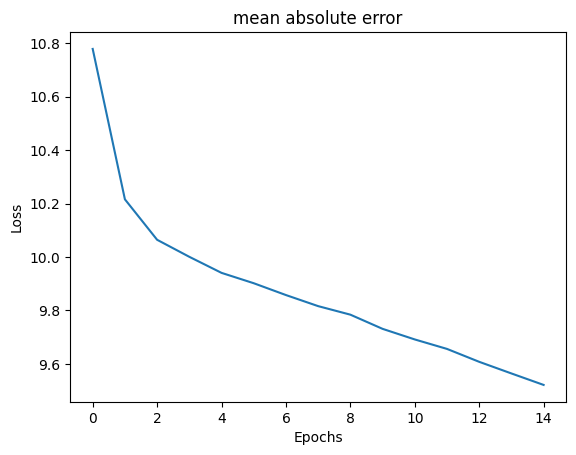

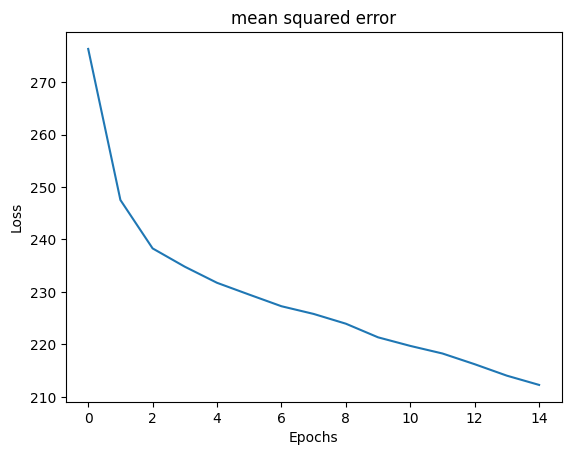

In [17]:

bn_dict = {}
l1_skip_bn = train(
    model_name = 'CIFAR-L1-skip-BN',
    model_size = 4,
    skip_connections = True,
    batch_norm = True,
    backprop_loss = 1,
    data = train_data,
    epochs=15
)
bn_dict['l1_skip'] = l1_skip
bn_dict['l1_skip_bn'] = l1_skip_bn

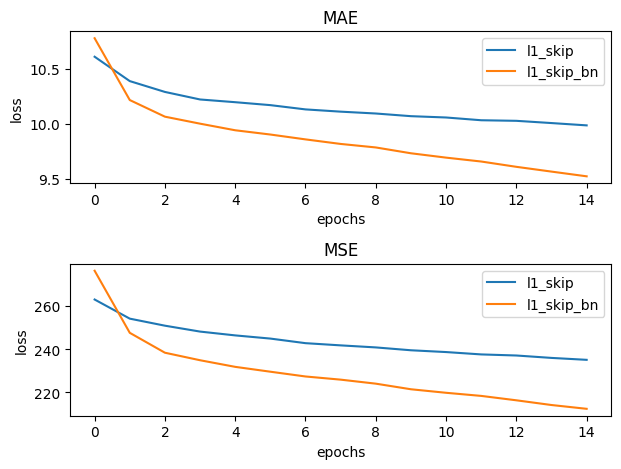

In [18]:
compare_plot(bn_dict, 'batch_normalisation')

The plot above shows the convergence curve of two unet models with skip connections. The difference between the models is the use of batch normalisation after each double convolution in the decoder and encoder of the architecture.

As we can see batch normalisation yields to better results.
We will keep batch normalisation is future implementations.

## Compare objective function used for backpropagation

Epoch 1/15:  MAE Loss: 10.842522883901792, MSE Loss: 270.6965036976094


Epoch 2/15:  MAE Loss: 10.448842184884208, MSE Loss: 243.38778406259965


Epoch 3/15:  MAE Loss: 10.276960090715058, MSE Loss: 232.36837005615234


Epoch 4/15:  MAE Loss: 10.218093507143916, MSE Loss: 228.19171508477658


Epoch 5/15:  MAE Loss: 10.169322938335185, MSE Loss: 225.69689980331734


Epoch 6/15:  MAE Loss: 10.139557040467555, MSE Loss: 223.831331836934


Epoch 7/15:  MAE Loss: 10.11049247761162, MSE Loss: 222.36582767720125


Epoch 8/15:  MAE Loss: 10.069776165242098, MSE Loss: 220.36176362329599


Epoch 9/15:  MAE Loss: 10.027741378667404, MSE Loss: 218.16963717402245


Epoch 10/15:  MAE Loss: 10.003618955612183, MSE Loss: 216.69492184385962


Epoch 11/15:  MAE Loss: 9.957344614729589, MSE Loss: 214.50569954696968


Epoch 12/15:  MAE Loss: 9.923741778548884, MSE Loss: 212.48395328132474


Epoch 13/15:  MAE Loss: 9.897042415579971, MSE Loss: 211.16536533589266


Epoch 14/15:  MAE Loss: 9.857819474473292, MSE Loss: 209.0665065998934


Epoch 15/15:  MAE Loss: 9.810317399550458, MSE Loss: 206.7305804661342


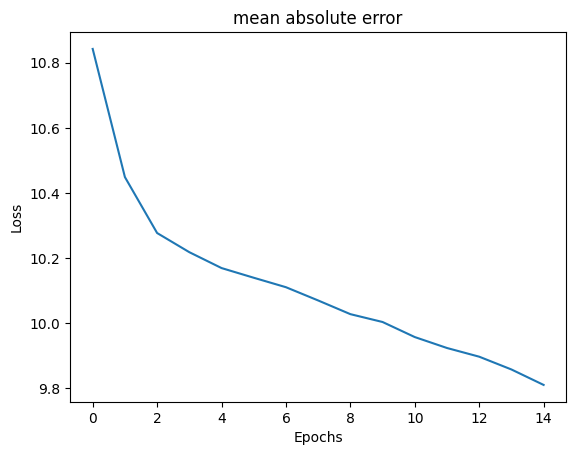

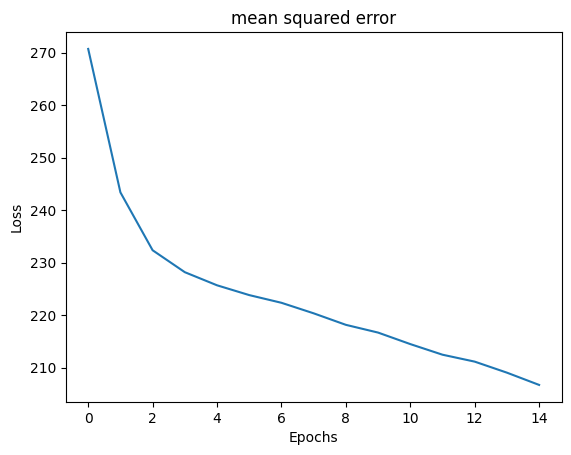

In [19]:
# unet without skip connections trained on L2 loss
loss_dict = {}
l2_skip_bn = train(
    model_name = 'CIFAR-L2-skip-BN',
    model_size = 4,
    skip_connections = True,
    batch_norm = True,
    backprop_loss = 2,
    data = train_data,
    epochs=15
)
loss_dict['l2_skip_bn'] = l2_skip_bn

Epoch 1/15:  MAE Loss: 10.805153408829046, MSE Loss: 268.10785861891145


Epoch 2/15:  MAE Loss: 10.330033132008143, MSE Loss: 238.62620186319157


Epoch 3/15:  MAE Loss: 10.167078957265737, MSE Loss: 228.33700740580656


Epoch 4/15:  MAE Loss: 10.122310915771795, MSE Loss: 225.18246989347497


Epoch 5/15:  MAE Loss: 10.065089790188537, MSE Loss: 222.43836453496192


Epoch 6/15:  MAE Loss: 10.038258080579796, MSE Loss: 220.98667269336934


Epoch 7/15:  MAE Loss: 10.001440622368637, MSE Loss: 218.8080217011121


Epoch 8/15:  MAE Loss: 9.962105220677902, MSE Loss: 216.8388207883251


Epoch 9/15:  MAE Loss: 9.930554336431076, MSE Loss: 215.16502520502831


Epoch 10/15:  MAE Loss: 9.870970458400492, MSE Loss: 212.13524254000916


Epoch 11/15:  MAE Loss: 9.844873204523203, MSE Loss: 210.77903358303772


Epoch 12/15:  MAE Loss: 9.799516780035836, MSE Loss: 208.51640280898735


Epoch 13/15:  MAE Loss: 9.755425579693853, MSE Loss: 206.1172937665667


Epoch 14/15:  MAE Loss: 9.718439564412954, MSE Loss: 204.14955621836137


Epoch 15/15:  MAE Loss: 9.661494585932518, MSE Loss: 201.23212705339705


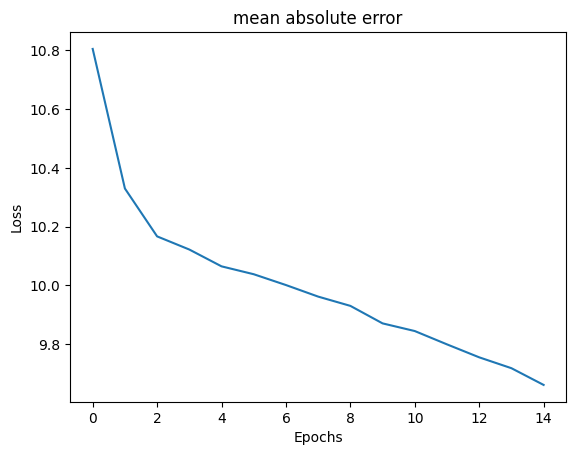

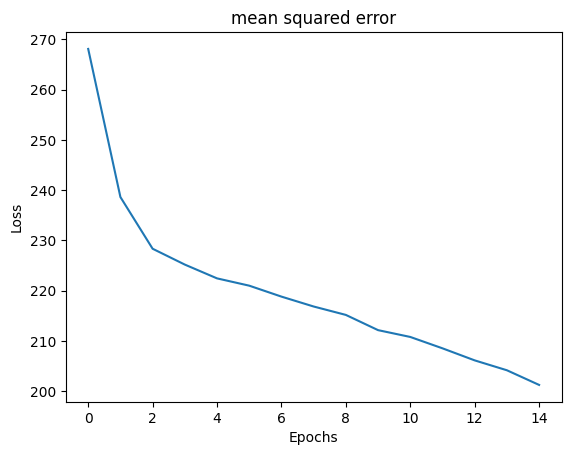

In [20]:
# unet with skip connections trained on L1 and L2 loss

l1l2_skip_bn = train(
    model_name = 'CIFAR-L1+L2-skip-BN',
    model_size = 4,
    skip_connections = True,
    batch_norm = True,
    backprop_loss = 0,
    data = train_data,
    epochs=15
)

loss_dict['l1l2_skip_bn'] = l1l2_skip_bn

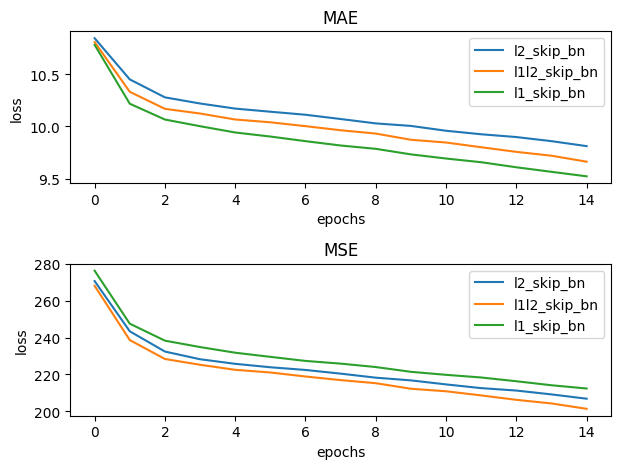

In [21]:
loss_dict['l1_skip_bn'] = l1_skip_bn
compare_plot(loss_dict, 'objective_function')

As we can see using MAE as a loss function for training results in a lower MAE during training and the opposite is true when using a MSE loss function. We will need another metric to evaluate the results.

Let's evaluate the models with The LPIPS metric on the testing dataset.

In [23]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00


In [66]:
from torch.types import Device
from lpips import LPIPS

lpips_alex = LPIPS(net='alex')

def lpips_evaluate(model, loader):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colors in loader:
            grayscale_images = grayscale_images
            colors = colors

            # Forward pass
            predicted_colors = model(grayscale_images)

            # Compute the loss
            predicted_rgb = to_rgb(grayscale_images, predicted_colors, to_numpy = False)
            label_rgb = to_rgb(grayscale_images, colors, to_numpy = False)

            loss = lpips_alex(predicted_rgb, label_rgb)

            # Accumulate loss
            running_loss += loss.sum().item()

    # Calculate average loss
    average_loss = running_loss / len(loader)

    return average_loss


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [67]:
l1_model = UNet(4, True, True)
l1_model.load_state_dict(torch.load('models/CIFAR-L1-skip-BN.pth'))

l2_model = UNet(4, True, True)
l2_model.load_state_dict(torch.load('models/CIFAR-L2-skip-BN.pth'))

l1l2_model = UNet(4, True, True)
l1l2_model.load_state_dict(torch.load('models/CIFAR-L1+L2-skip-BN.pth'))

testloader = DataLoader(test_data, batch_size=256)
trainloader = DataLoader(train_data, batch_size=256)

In [68]:
l1_test_lpips = lpips_evaluate(l1_model, testloader)
l2_test_lpips = lpips_evaluate(l2_model, testloader)
l1l2_test_lpips = lpips_evaluate(l1l2_model, testloader)
print(f'''LPIPS results on test data:
using MAE loss:{l1_test_lpips}
using MSE loss:{l2_test_lpips}
using both loss:{l1l2_test_lpips}  ''')

LPIPS results on test data:
using MAE loss:16.639101833105087  
using MSE loss:15.107490301132202  
using both loss:15.00098034441471  


In [69]:
l1_train_lpips = lpips_evaluate(l1_model, trainloader)
l2_train_lpips = lpips_evaluate(l2_model, trainloader)
l1l2_train_lpips = lpips_evaluate(l1l2_model, trainloader)
print(f'''LPIPS results on train data:
using MAE loss:{l1_test_lpips}
using MSE loss:{l2_test_lpips}
using both loss:{l1l2_test_lpips}  ''')

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return func(*args, **kwargs)


LPIPS results on train data:
using MAE loss:16.639101833105087  
using MSE loss:15.107490301132202  
using both loss:15.00098034441471  


As we can see we find the lowest lpips loss using the l1 and l2 loss simultanuously during training.

We will keep this for future implementations.